In [1]:
import sympy as sp
import numpy as np
from math import *
from time import perf_counter as timer
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy.random as rnd
from math import ceil

In [2]:
class Transition:

    def __init__(self, update, rate, sympy_symbols):
        #this will convert rate into a sympy expression.

        self.update = None
        self.update_dictionary = update
        try:
            self.rate = sp.sympify(rate, sympy_symbols, evaluate=False)
        except sp.SympifyError as e:
            print("An error happened while parsing expression", rate,":",e)

    # finalizes transition by turning the update list into a numpy array
    def finalize(self, variables):
        self.update = np.zeros(variables.dimension)
        for var_name in self.update_dictionary:
            index = variables.get_id(var_name)
            self.update[index] = self.update_dictionary[var_name]
        self.update = np.reshape(self.update, (1,variables.dimension))

In [3]:
class Symbols:

    def __init__(self):
        # initialize
        self.reference = []
        self.values = []
        # initialize map from string to int and back
        self.reference2id = {}
        self.names2id = {}
        self.id2reference = {}
        self.dimension = 0

    #Adds a new symbol to the symbol array, creating a sympy object
    def add(self, name, value):
        symbol = sp.symbols(name)
        index = len(self.reference)
        self.reference.append(symbol)
        self.values.append(value)
        self.reference2id[symbol] = index
        self.names2id[name] = index
        self.id2reference[index] = symbol
        self.dimension += 1
        return symbol

    # sets the value of a symbol
    def set(self, name, value):
        try:
            index = self.names2id[name]
            self.values[index] = value
        except:
            print("Symbol " + name + " is not defined")

    def get_value(self,name):
        try:
            index = self.names2id[name]
            return self.values[index]
        except:
            print("Symbol " + name + " is not defined")

    #finalizes the symbol array, generating a numpy array for values
    def finalize(self):
        self.values = np.array(self.values)

    def get_id(self, name):
        return self.names2id[name]


In [4]:
class Model:

    def __init__(self):
        #init variables and parameters
        self.variables = Symbols()
        self.parameters = Symbols()
        # this contains a map of names to sympy variables, to be used later for parsing expressions
        self.names2sym = {}
        # init transition list
        self.transitions = []
        self.transition_number = 0
        self.system_size = 0;
        self.system_size_reference = None
        self.system_size_name = ''
        self.variables_names = []

    def set_system_size(self, name, value):
        self.add_parameter(name, value)
        self.system_size_reference = self.names2sym[name]
        self.system_size_name = name
        self.system_size = value


    def add_variable(self, name, value):
        if name in self.names2sym:
            raise ModelError("Name " + name + " already defined!")
        var = self.variables.add(name, value)
        self.variables_names.append(name)
        self.names2sym[name] = var

    def add_parameter(self, name, value):
        if name in self.names2sym:
            raise ModelError("Name " + name + " already defined!")
        par = self.parameters.add(name, value)
        self.names2sym[name] = par

    # Changes the initial value of a variable
    def set_variable(self, name, value):
        self.variables.set(name, value)

    # Changes the value of a parameter
    def set_parameter(self, name, value):
        if self.system_size_name == name:
            self.parameters.set(name, value)
            self.system_size = value
        else:
            self.parameters.set(name, value)

    def get_parameter_value(self, name):
        return self.parameters.get_value(name)

    # Adds a transition to the model
    def add_transition(self, update, rate):
        t = Transition(update, rate, self.names2sym)
        self.transitions.append(t)
        self.transition_number += 1



    # Finalizes the initialization
    def finalize_initialization(self):
        self.variables.finalize()
        self.parameters.finalize()
        for t in self.transitions:
            t.finalize(self.variables)
        
        self.__generate_vector_field()
        self.__generate_diffusion()
        self.__generate_jacobian()
        self.__generate_numpy_functions()

    #generates the mean field vector field
    def __generate_vector_field(self):
        self._vector_field_sympy = np.zeros(self.transitions[0].update.shape, dtype=object)
        #update is the update vector, hence its shape is the number of variables
        
        for i in range(len(self.variables_names)):
            self._vector_field_sympy[0,i] = 0
            for rho in self.transitions:
                self._vector_field_sympy[0,i] = self._vector_field_sympy[0,i] + rho.update[0,i]*rho.rate         
            
        self._vector_field_sympy = sp.simplify(self._vector_field_sympy)
        

    #generates the diffusion term
    def __generate_diffusion(self):
        n_vars = self.variables.dimension
        self._diffusion_sympy = np.zeros((n_vars, n_vars), dtype = object)
        
        for i in range(n_vars):
            for k in range(n_vars):
                for rho in self.transitions:
                    self._diffusion_sympy[i,k] = self._diffusion_sympy[i,k] + rho.update[0,i]*rho.update[0,k]*rho.rate
        
        self._diffusion_sympy = sp.simplify(self._diffusion_sympy)
        

    # computes symbolically the jacobian of the vector field
    def __generate_jacobian(self):
        n = self.variables.dimension
        f = self._vector_field_sympy
        x = self.variables.reference
        J = np.zeros((n, n), dtype=object)
        
        for i in range(n):
            for j in range(n):
                J[i,j] = sp.diff(f[0,i], x[j])
               
        self._jacobian_sympy = J


    # generate numpy expressions and the mean field VF
    def __generate_numpy_functions(self):
        sympy_ref = self.variables.reference + self.parameters.reference
        self.rates = sp.lambdify(sympy_ref, [t.rate for t in self.transitions], "numpy")
        self.vector_field = sp.lambdify(sympy_ref, self._vector_field_sympy, "numpy")
        self.diffusion = sp.lambdify(sympy_ref, self._diffusion_sympy, "numpy")
        self.jacobian = sp.lambdify(sympy_ref, self._jacobian_sympy, "numpy")
        

    #evaluates and returns vector field, diffusion, ...
    def evaluate_all_vector_fields(self, var_values):
        f = self.vector_field(*var_values, *self.parameters.values)
        D = self.diffusion(*var_values, *self.parameters.values)
        J = self.jacobian(*var_values, *self.parameters.values)
        return np.asarray(f), np.asarray(D), np.asarray(J)

    def evaluate_MF_vector_field(self, var_values):
        f = self.vector_field(*var_values, *self.parameters.values)
        return np.asarray(f)


    def evaluate_rates(self, var_values):
        r = self.rates(*var_values, *self.parameters.values)
        return np.asarray(r)


- Class containing the methods to plot trajectories and compare the results of different methods. 

In [5]:
class Trajectory:
    def __init__(self, t, x, desc, labels):
        self.time = t
        self.data = x
        self.labels = labels
        self.description = desc

    def plot(self, var_to_plot=None):
        if var_to_plot is None:
            var_to_plot = self.labels
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set_prop_cycle(plt.cycler('color', ['r', 'g', 'b', 'c', 'm', 'y', 'k']))
        handles = []
        labels = []
        for v in var_to_plot:
            try:
                i = self.labels.index(v)
                h, = ax.plot(self.time, self.data[:, i])
                handles.append(h)
                labels.append(v)
            except:
                print("Variable", v, "not found")
        fig.legend(handles, labels)
        plt.title(self.description)
        plt.xlabel('Time')
        plt.show()

    def plot_comparing_to(self, trajectory, var_to_plot=None):
        if var_to_plot is None:
            var_to_plot = self.labels
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set_prop_cycle(plt.cycler('color', ['r', 'r', 'g', 'g', 'b', 'b', 'c', 'c', 'm', 'm', 'y', 'y', 'k', 'k']))
        handles = []
        labels = []
        for v in var_to_plot:
            try:
                i = self.labels.index(v)
                h, = ax.plot(self.time, self.data[:, i])
                handles.append(h)
                labels.append(self.description + " " + v)
                h, = ax.plot(trajectory.time, trajectory.data[:, i], '--')
                handles.append(h)
                labels.append(trajectory.description + " " + v)
            except Exception as e:
                print("Probably variable", v, "not found")
                print("Exception is", e)
        fig.legend(handles, labels)
        plt.title(self.description + " vs " + trajectory.description)
        plt.xlabel('Time')
        plt.show()

- Class containing all the methods for generating PCTMC trajectories: from SSA simulation to stochastic approximation (e.g. Mean Field and Linear Noise)

In [6]:
class Simulator:
    def __init__(self, model):
        self.model = model
        self.t0 = 0
        self.x0 = model.variables.values

    def _unpack(self, z):
        n = self.model.variables.dimension
        phi = z[0:n]  # mean field
        c = np.reshape(z[n:], (n, n))  # c term
        return phi, c

    def _pack(self, f, dc):
        z = np.concatenate((f.flatten(), dc.flatten()))
        return z

    # computes the full vector field for the linear noise ODE
    def _linear_noise_ODE(self, z, t):
        x_t, c_t = self._unpack(z)
        
        f, D, J = self.model.evaluate_all_vector_fields(x_t)
        dx_dt = np.dot(J,x_t)
        dc_dt = np.dot(J,c_t) + np.dot(c_t, J) + D
        
        dz = self._pack(dx_dt, dc_dt)
        return dz

    # computes the vector field for the classic mean field
    def _mean_field_ODE(self, x, t):
        
        dx_dt = self.model.evaluate_MF_vector_field(x)[0]
        return dx_dt


    def _generate_time_stamp(self, final_time, points):
        """
        Generates a time stamp from time self.t0 to final_time,
        with points+1 number of points.

        :param final_time: final time of the simulation
        :param points: number of points
        :return: a time stamp numpy array
        """
        step = (final_time - self.t0) / points
        time = np.arange(self.t0, final_time + step, step)
        return time

    def MF_simulation(self, final_time, points=1000):
        """
        Numerically integrates standard mean field equations

        :param final_time: final simulation time
        :param points: number of points to be saved
        :return:  a trajectory object for model observables
        """
        t = self._generate_time_stamp(final_time, points)
        x = odeint(self._mean_field_ODE, self.x0, t)
        t = np.reshape(t, (len(t), 1))
        trajectory = Trajectory(t, x, "Mean Field", self.model.variables_names)
        return trajectory

    def LN_simulation(self, final_time, points=1000):
        """
        Numerically integrates the linear noise equations

        :param final_time: final simulation time
        :param points: number of points to be saved
        :return:  a trajectory object for corrected model observables
        """
        n = self.model.variables.dimension
        t = self._generate_time_stamp(final_time, points)
        c0 = np.zeros((n,n))
        z0 = self._pack(self.x0, c0)
        z = odeint(self._linear_noise_ODE, z0, t)

        x = z[:,0:n]
        c = np.reshape(z[:,n:], (points+1,n,n))
        
        trajectory = Trajectory(t, x, "Linear noise", self.model.variables_names)
        
        return trajectory, t, x, c

- Define a basic PCTMC model of your choice using the class *Model()*.

In [8]:
sir = Model()
# variables are generated in the following order
#Current data retrievable from https://lab24.ilsole24ore.com/coronavirus/#
N = 6e+07 #Italian population
Current_infected = 491630
Current_recovered =  1897861
sir.add_variable("S", N-Current_infected-Current_recovered)
sir.add_variable("I", Current_infected)
sir.add_variable("R", Current_recovered)
# Adding parameters
sir.add_parameter("ki", 10/14)
sir.add_parameter("kr", 1/14) #1/days to change state
sir.add_parameter("ks", 1/90)
#setting the system size N
sir.set_system_size("N", N) 
# Adding transitions, using a dictionary to represent the update vector
sir.add_transition({"S":-1, "I":1}, "ki/N*I*S") # TODO: i am super unsure regarding the rates and the division by n
sir.add_transition({"I":-1, "R":1}, "kr*I")
sir.add_transition({"R":-1, "S":1}, "ks*R")
#finalize initialization
sir.finalize_initialization()

In [9]:
sir.transitions[0].update
len(sir.variables_names)
sir._vector_field_sympy[0,1]

1.0*I*(-N*kr + S*ki)/N

In [10]:
#initialize simulator
sim = Simulator(sir)
final_time = 25
points = 100

In [11]:
#integrate mf ode
start = timer()
traj_mf = sim.MF_simulation(final_time, points)
end = timer()
print("MF simulation time:", (end-start), "seconds")

MF simulation time: 0.006063600001652958 seconds


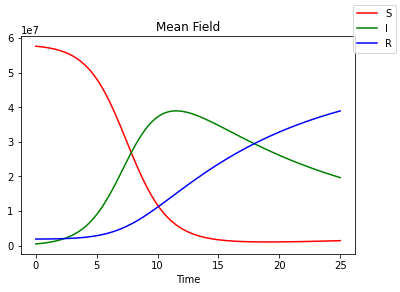

In [12]:
if __name__ == "__main__":
    traj_mf.plot()

In [13]:
#integrate ln ode
start = timer()
traj_ln, t, mf, cov = sim.LN_simulation(final_time, points)
end = timer()
print("LN simulation time:", (end-start), "seconds")

LN simulation time: 0.08332240000163438 seconds


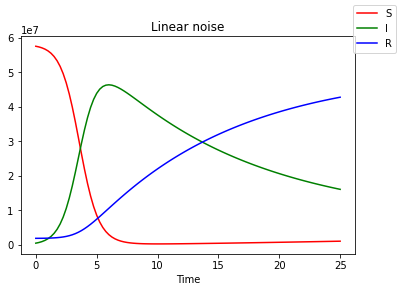

In [14]:
traj_ln.plot()